In [1]:
from collections import defaultdict, Counter
import json
from tqdm import tqdm
import os
from pathlib import Path

import ast
import cv2
import dask
import dask.array as da
import dask.dataframe as dd
from dask import delayed
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
# --- 1. 기본 경로 및 파일 경로 설정 ---
base_dir = Path(os.getcwd()).resolve().parent
data_path = base_dir / "assets"
json_path = base_dir / "preprocessed_data_json"

# 카테고리 정보 로드
with (data_path / "categories.json").open("r", encoding="utf-8") as f:
    categories = json.load(f)

categories_df = pd.DataFrame(categories)

# 'name' 컬럼을 '@' 기준으로 분리하여 새로운 컬럼 생성
# .str.split()에 expand=True를 사용하면 분리된 결과가 새로운 컬럼들로 만들어집니다.
categories_df[['category_group', 'category_name']] = categories_df['name'].str.split('@', n=1, expand=True)

# 'id'를 인덱스로 설정하여 특정 카테고리를 빠르게 찾을 수 있도록 함
categories_df = categories_df.set_index('id')

In [3]:
# 1. 파일을 한번만 읽어 필요한 모든 '부분'을 반환하는 함수
def load_all_parts_from_file(json_file_path):
    """파일을 한 번만 읽고 images와 annotations 리스트를 딕셔너리로 반환합니다."""
    with open(json_file_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    
    return {
        'info': data.get('info', []),
        'images': data.get('images', []),
        'annotations': data.get('annotations', [])
    }

# 파일 목록 가져오기
file_list = sorted(json_path.glob("TL_prepro/TL_*_*/*.json"))

# 2. 각 파일에 대해 로더 함수를 '지연' 실행. (파일 읽기 I/O는 여기서 한 번만 계획됨)
lazy_results = [delayed(load_all_parts_from_file)(f) for f in file_list]

# 3. '지연된' 결과(딕셔너리)를 '재사용'하여 각 데이터프레임을 생성
# 3-1. info 데이터프레임 만들기
lazy_infos_dfs = [delayed(pd.json_normalize)(res['info']) for res in lazy_results]
infos_ddf = dd.from_delayed(lazy_infos_dfs)
# 3-2. images 데이터프레임 만들기
lazy_images_dfs = [delayed(pd.json_normalize)(res['images']) for res in lazy_results]
images_ddf = dd.from_delayed(lazy_images_dfs)

# 3-3. annotations 데이터프레임 만들기
lazy_annotations_dfs = [delayed(pd.json_normalize)(res['annotations']) for res in lazy_results]
annotations_ddf = dd.from_delayed(lazy_annotations_dfs)


# 이제 두 개의 Dask DataFrame이 효율적으로 생성되었습니다.
# print("--- Infos DataFrame Head ---")
# display(infos_ddf.compute().head())

# print("--- Images DataFrame Head ---")
# display(images_ddf.compute().head())

print("\n--- Annotations DataFrame Head ---")
# display(annotations_ddf.compute().head())
# display(annotations_ddf.compute().info())


--- Annotations DataFrame Head ---


In [4]:
annotations_ddf['bbox'] = annotations_ddf['bbox'].map(
    ast.literal_eval, 
    meta=('bbox', 'object')
)

In [5]:
def expand_bbox_with_coords(bbox_list):
    x, y, w, h = bbox_list
    x2 = x + w
    y2 = y + h
    return pd.Series([x, y, w, h, x2, y2], index=['x', 'y', 'w', 'h', 'x2', 'y2'])

# .apply에 직접 만든 함수를 전달
new_cols = annotations_ddf['bbox'].apply(
    expand_bbox_with_coords,
    meta={'x': 'f8', 'y': 'f8', 'w': 'f8', 'h': 'f8', 'x2': 'f8', 'y2': 'f8'}
)

annotations_ddf = dd.concat([annotations_ddf, new_cols], axis=1)

# display(annotations_ddf.compute().head())

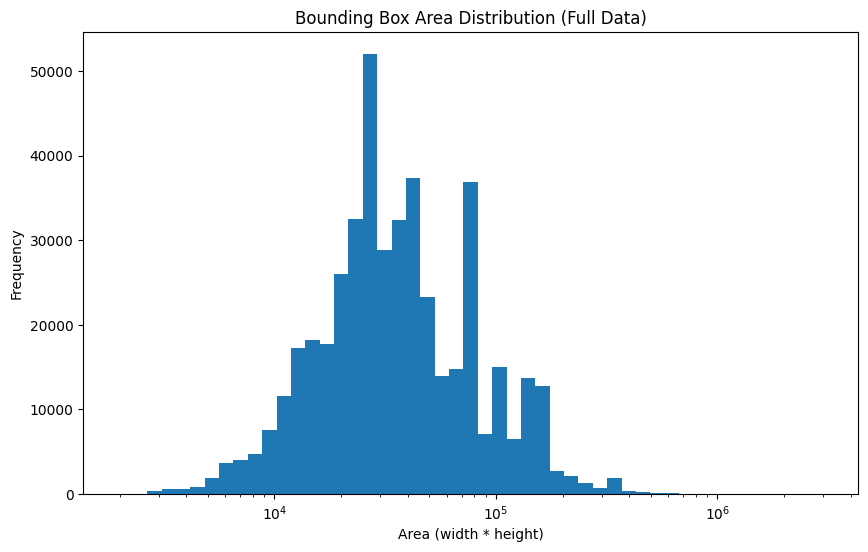

/home/rune/.pyenv/versions/3.11.13/lib/python3.11/site-packages/dask/dataframe/core.py:382: UserWarning: Insufficient elements for `head`. 5 elements requested, only 0 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(


In [6]:
# 1. Dask를 사용해 히스토그램을 '계산할 계획'을 세웁니다.
# bins를 50개로 설정하고, area 컬럼의 min/max 값도 dask로 계산합니다.
area_min, area_max = dd.compute(annotations_ddf['area'].min(), annotations_ddf['area'].max())
bins = np.logspace(np.log10(max(area_min, 1)), np.log10(area_max), 50) # 로그 스케일 빈 생성

counts, bin_edges = da.histogram(annotations_ddf['area'], bins=bins)

# 2. .compute()를 호출하여 실제 계산을 실행합니다.
# 이 결과는 매우 작은 numpy 배열이므로 메모리에 부담이 없습니다.
computed_counts, computed_bin_edges = dask.compute(counts, bin_edges)

# 3. 계산된 '결과'를 사용해 Matplotlib로 직접 플로팅합니다.
plt.figure(figsize=(10, 6))
# 막대 그래프의 너비를 계산합니다.
bin_widths = np.diff(computed_bin_edges)
plt.bar(computed_bin_edges[:-1], computed_counts, width=bin_widths, align='edge')

plt.title('Bounding Box Area Distribution (Full Data)')
plt.xlabel('Area (width * height)')
plt.ylabel('Frequency')
plt.xscale('log') # x축을 로그 스케일로 설정
plt.show()

In [6]:
def cal_bbox_info(bbox_list):
    x, y, w, h = bbox_list
    aspect_ratio = w / (h if h != 0 else 1e-6)
    center_x = (x + w) / 2
    center_y = (y + h) / 2
    return pd.Series([aspect_ratio, center_x, center_y], index=['aspect_ratio', 'center_x', 'center_y'])

new_cols = annotations_ddf['bbox'].apply(
    cal_bbox_info,
    meta={'aspect_ratio': 'f8', 'center_x': 'f8', 'center_y': 'f8'}
)

annotations_ddf = dd.concat([annotations_ddf, new_cols], axis=1)

# display(annotations_ddf.compute().head())

In [ ]:
# zero_aspect_ratio_annotations = annotations_ddf[annotations_ddf['aspect_ratio'] == 0]
# print(len(zero_aspect_ratio_annotations))

# 0에 매우 가까운 값들 (예: -0.1 ~ 0.1 사이)을 찾아봅니다.
near_zero_annotations = annotations_ddf[
    (annotations_ddf['aspect_ratio'] > -0.1) & (annotations_ddf['aspect_ratio'] < 0.1)
]

# 계산 후 일부 데이터 확인
# w는 매우 작고, h는 매우 큰 값들이 나올 것으로 예상됩니다.
if len(near_zero_annotations) > 0:
    print("0에 가까운 종횡비를 가진 데이터 샘플:")
    print(near_zero_annotations[['w', 'h', 'aspect_ratio']].compute().head()) # Dask DataFrame이므로 compute() 호출
else:
    print("0에 가까운 데이터를 찾을 수 없습니다. (다른 원인일 수 있습니다)")

전체 데이터 히스토그램 계산 중...
계산 완료.
시각화 생성 중...


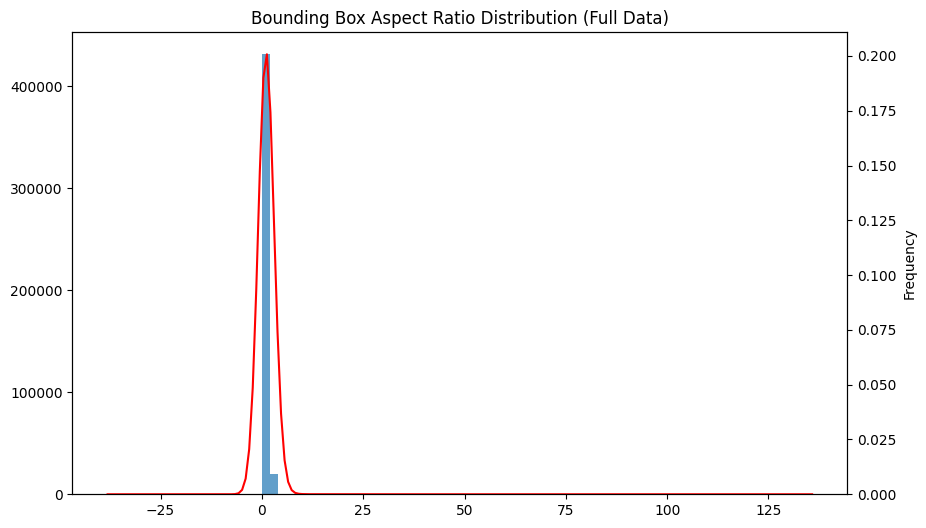

In [ ]:
# 이미지의 모양이 어떻게 되는가?

# --- 1. Dask를 이용해 전체 데이터의 히스토그램 정보 계산 ---
print("전체 데이터 히스토그램 계산 중...")
# 히스토그램의 범위(최솟값, 최댓값)를 먼저 계산합니다.
ar_min, ar_max = dd.compute(annotations_ddf['aspect_ratio'].min(), annotations_ddf['aspect_ratio'].max())

# 최솟값과 최댓값 사이를 50개의 구간(bins)으로 나눕니다.
bins = np.linspace(ar_min, ar_max, 51) # 51개의 경계값이 50개의 구간을 만듭니다.

# Dask로 히스토그램의 각 구간별 개수(counts)와 경계(bin_edges)를 계산합니다.
counts, bin_edges = da.histogram(annotations_ddf['aspect_ratio'], bins=bins)

# 실제 계산을 실행하여 작은 결과(Numpy 배열)를 메모리로 가져옵니다.
computed_counts, computed_bin_edges = dask.compute(counts, bin_edges)
print("계산 완료.")


# --- 2. 계산된 결과를 Matplotlib으로 시각화 ---
print("시각화 생성 중...")
plt.figure(figsize=(10, 6))

# 막대 그래프의 너비를 계산합니다.
bin_widths = np.diff(computed_bin_edges)
# 막대 그래프를 그립니다.
plt.bar(computed_bin_edges[:-1], computed_counts, width=bin_widths, align='edge', alpha=0.7)

# KDE(밀도 곡선)를 직접 그려서 추가할 수도 있습니다. (선택 사항)
# sns.kdeplot을 사용하기 위해 bin의 중앙값과 가중치를 사용합니다.
bin_centers = (computed_bin_edges[:-1] + computed_bin_edges[1:]) / 2
sns.kdeplot(x=bin_centers, weights=computed_counts, color='red', ax=plt.gca().twinx())


plt.title('Bounding Box Aspect Ratio Distribution (Full Data)')
plt.xlabel('Aspect Ratio (width / height)')
plt.ylabel('Frequency')
plt.show()

작은 images_ddf를 메모리로 로드 중...
로드 완료.
map_partitions으로 병합 계획 수립 중...
시각화용 데이터 계산 중 (2D 히스토그램)...
계산 완료.
Matplotlib으로 시각화 생성 중...


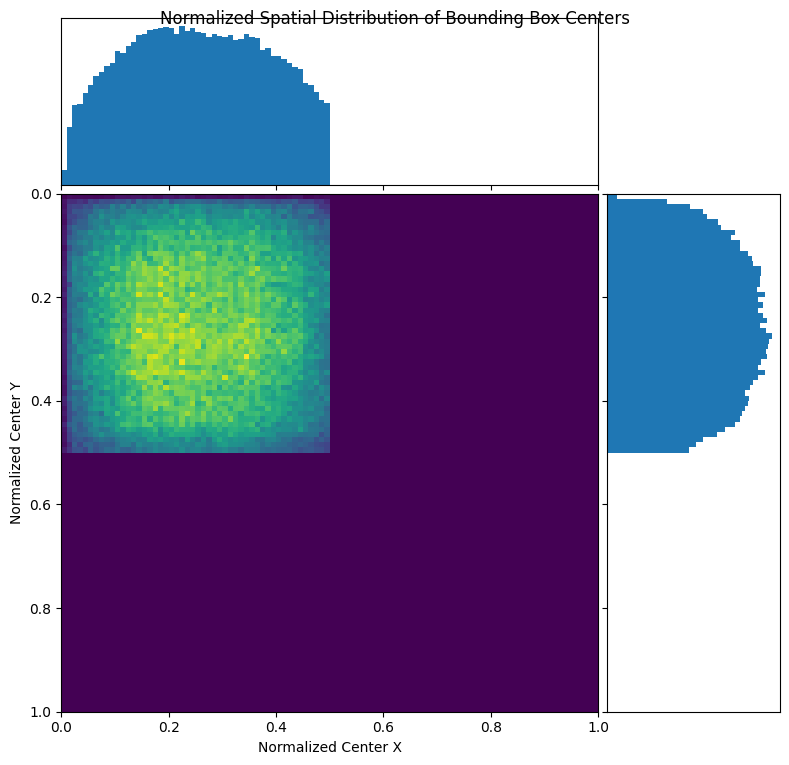

In [7]:
import matplotlib.gridspec as gridspec

# 이미지에서 박스들이 주로 어느 위치에 존재하는가?
# 클래스마다 나타나는 위치가 다른가?

# --- 최적화 단계 (데이터 타입 최적화는 여전히 유효) ---
images_ddf['id'] = images_ddf['id'].astype('str')
images_ddf['width'] = images_ddf['width'].astype('int16')
images_ddf['height'] = images_ddf['height'].astype('int16')

annotations_ddf['image_id'] = annotations_ddf['image_id'].astype('str')
annotations_ddf['center_x'] = annotations_ddf['center_x'].astype('float32')
annotations_ddf['center_y'] = annotations_ddf['center_y'].astype('float32')

# --- 1. 작은 DataFrame을 Pandas로 변환하고 필요한 컬럼만 선택 ---
print("작은 images_ddf를 메모리로 로드 중...")
images_pdf = images_ddf[['id', 'width', 'height']].rename(columns={'id': 'image_id'}).compute()
print("로드 완료.")

# --- 2. map_partitions를 이용한 병합 ---
print("map_partitions으로 병합 계획 수립 중...")
# 병합에 필요한 annotations 컬럼만 선택
annotations_to_merge = annotations_ddf[['image_id', 'center_x', 'center_y']]

def merge_with_images(annotations_partition, images_lookup_df):
    """annotations의 한 파티션과 전체 image 데이터를 Pandas로 merge하는 함수"""
    # return pd.merge(annotations_partition, images_lookup_df, on='image_id')
    merged_partition = pd.merge(annotations_partition, images_lookup_df, on='image_id')
    merged_partition['norm_center_x'] = merged_partition['center_x'] / merged_partition['width']
    merged_partition['norm_center_y'] = merged_partition['center_y'] / merged_partition['height']
    
    return merged_partition

# map_partitions의 결과물 형태를 Dask에게 명확히 알려주기 위한 meta 정보
# 이 meta는 merge_with_images 함수가 반환하는 DataFrame의 구조와 정확히 일치해야 합니다.
meta_df = pd.DataFrame({
    'image_id': pd.Series(dtype='str'),
    'center_x': pd.Series(dtype='float32'),
    'center_y': pd.Series(dtype='float32'),
    'width': pd.Series(dtype='int16'),
    'height': pd.Series(dtype='int16'),
    'norm_center_x': pd.Series(dtype='float64'),
    'norm_center_y': pd.Series(dtype='float64'),
})

dask_merged = annotations_to_merge.map_partitions(
    merge_with_images,
    images_lookup_df=images_pdf,
    meta=meta_df
)


# --- 3. 정규화 및 시각화---
# 정규화된 중심점 좌표를 계산합니다.
# dask_merged['norm_center_x'] = dask_merged['center_x'] / dask_merged['width']
# dask_merged['norm_center_y'] = dask_merged['center_y'] / dask_merged['height']


# --- 2. 시각화에 필요한 2D 히스토그램 정보 미리 계산 ---
print("시각화용 데이터 계산 중 (2D 히스토그램)...")
# hexbin의 grid 크기 (숫자가 클수록 육각형이 작고 촘촘해짐)
gridsize = 100
bins = [gridsize, gridsize]
# x, y 좌표의 범위는 0과 1 사이
range_ = [[0, 1], [0, 1]]

# Dask로 2D 히스토그램을 계산합니다.
H, xedges, yedges = da.histogram2d(
    dask_merged['norm_center_x'].values,
    dask_merged['norm_center_y'].values,
    bins=bins,
    range=range_
)

# 실제 계산을 실행하여 작은 결과(행렬 H와 경계값)만 메모리로 가져옵니다.
computed_H, computed_xedges, computed_yedges = dask.compute(H, xedges, yedges)
print("계산 완료.")

# --- 3. 계산된 결과를 Matplotlib으로 직접 시각화 ---
print("Matplotlib으로 시각화 생성 중...")
# jointplot과 유사한 레이아웃을 직접 만듭니다.
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(4, 4)
ax_main = fig.add_subplot(gs[1:4, 0:3])
ax_top = fig.add_subplot(gs[0, 0:3], sharex=ax_main)
ax_right = fig.add_subplot(gs[1:4, 3], sharey=ax_main)

# 메인 2D 히스토그램 (hexbin 대신 pcolormesh 사용)
im = ax_main.pcolormesh(computed_xedges, computed_yedges, computed_H.T, cmap='viridis')
ax_main.set_xlabel('Normalized Center X')
ax_main.set_ylabel('Normalized Center Y')

# 상단 1D 히스토그램
x_counts = computed_H.sum(axis=1)
ax_top.bar(computed_xedges[:-1], x_counts, width=np.diff(computed_xedges), align='edge')
plt.setp(ax_top.get_xticklabels(), visible=False)
ax_top.set_yticks([])

# 오른쪽 1D 히스토그램
y_counts = computed_H.sum(axis=0)
ax_right.barh(computed_yedges[:-1], y_counts, height=np.diff(computed_yedges), align='edge')
plt.setp(ax_right.get_yticklabels(), visible=False)
ax_right.set_xticks([])

# 전체 제목 및 레이아웃 조정
fig.suptitle('Normalized Spatial Distribution of Bounding Box Centers', y=0.95)
ax_main.invert_yaxis() # y축 뒤집기
gs.tight_layout(fig)
gs.update(wspace=0.05, hspace=0.05)

plt.show()

히스토그램 계산 및 시각화 생성 중...


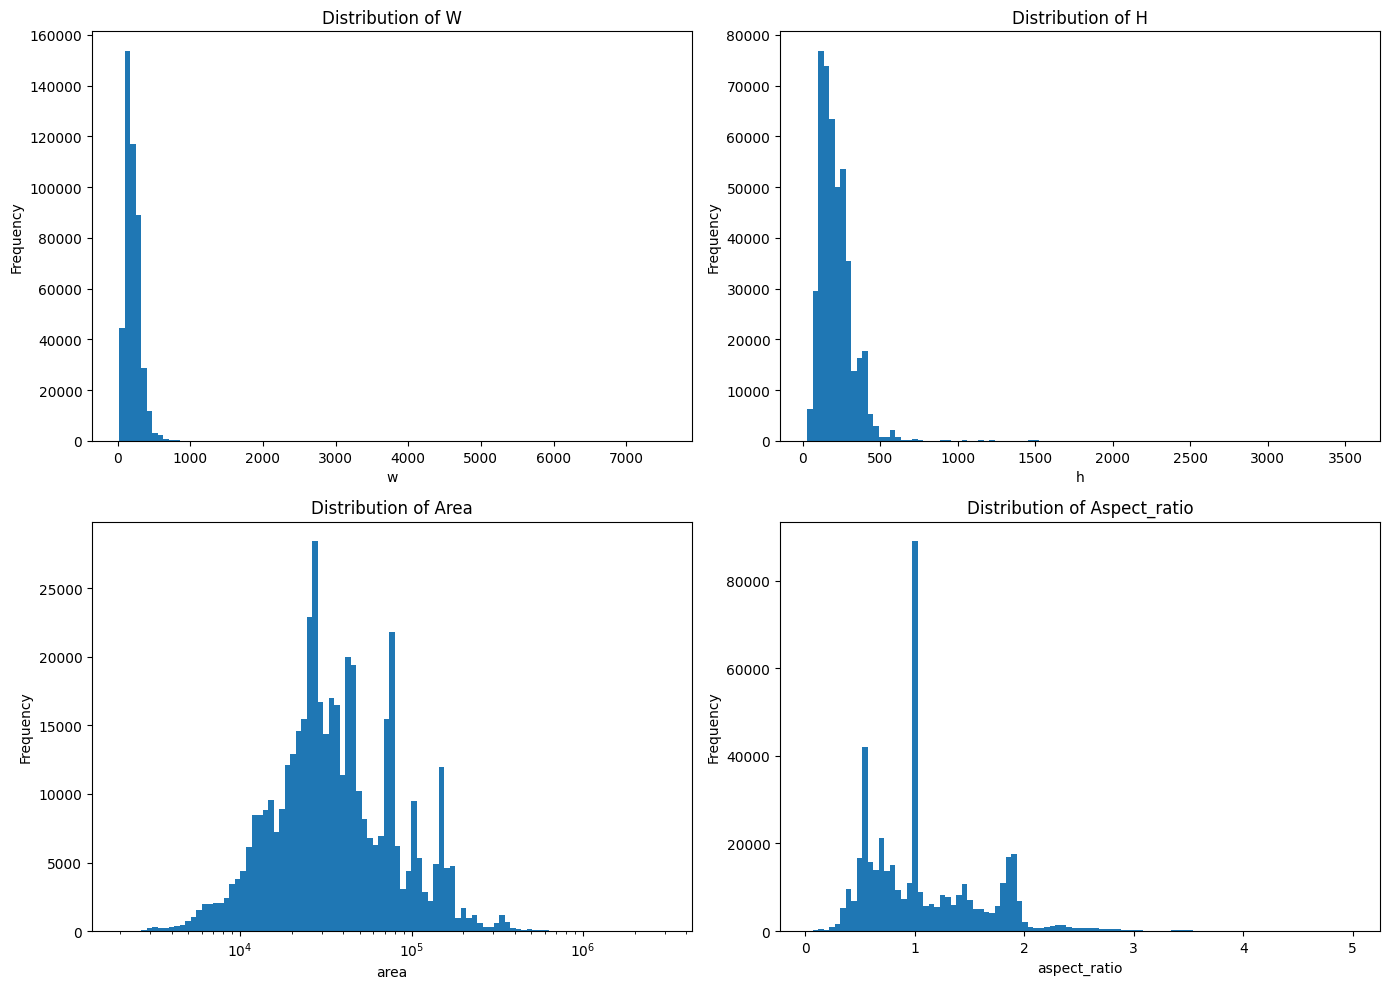

In [ ]:
# 객체는 어떤 크기/형태가 많은가?

# 분석할 컬럼 리스트
features_to_plot = ['w', 'h', 'area', 'aspect_ratio']

# 2x2 서브플롯 생성
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten() # 2x2 배열을 1차원으로 만듬

print("히스토그램 계산 및 시각화 생성 중...")
for i, feature in enumerate(features_to_plot):
    ax = axes[i]
    
    # 1. NaN 값과 무한대 값을 제외한 유효한 데이터만 선택
    # 직접 계산하셨더라도 오류 등으로 NaN 값이 있을 수 있으므로, 이 단계는 안전장치로 유지하는 것이 좋습니다.
    valid_data = annotations_ddf[feature].dropna()
    valid_data = valid_data[~valid_data.isin([np.inf, -np.inf])]

    # 2. 데이터의 min, max 값 계산
    min_val, max_val = dask.compute(valid_data.min(), valid_data.max())
    
    # 3. 히스토그램 bin 생성
    if feature == 'area' and min_val > 0:
        bins = np.logspace(np.log10(min_val), np.log10(max_val), 100)
        ax.set_xscale('log')
    else:
        if feature == 'aspect_ratio':
            # 종횡비는 특정 범위(예: 0~5)에 집중해서 볼 수 있습니다.
            min_val, max_val = max(0, min_val), min(5, max_val) 
        bins = np.linspace(min_val, max_val, 100)

    # 4. Dask로 히스토그램 계산
    counts, bin_edges = da.histogram(valid_data.values, bins=bins)
    computed_counts, computed_bin_edges = dask.compute(counts, bin_edges)
    
    # 5. 서브플롯에 막대그래프 그리기
    ax.bar(
        computed_bin_edges[:-1], 
        computed_counts, 
        width=np.diff(computed_bin_edges), 
        align='edge'
    )
    ax.set_title(f'Distribution of {feature.capitalize()}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')

fig.tight_layout()
plt.show()

In [7]:
# 클래스마다 크기 차이가 있는가? 상위 15개만 추려서 계산

# --- 1. Top 15 빈도수 카테고리 선택---
top_15_categories = annotations_ddf['category_id'].value_counts().nlargest(15).compute()
top_15_ids = top_15_categories.index.tolist()
filtered_ddf = annotations_ddf[annotations_ddf['category_id'].isin(top_15_ids)]

# --- 2. Dask로 박스 플롯 통계치 계산 ---
# 2-1. Quantile을 리스트로 묶어 한 번에 계산 (이전과 동일)
stats_series_ddf = filtered_ddf.groupby('category_id')['area'].apply(
    lambda x: x.quantile([0.25, 0.50, 0.75]),
    meta=pd.Series(dtype='float64', name='area')
)

# 2-2. Dask 계산을 실행하여 Pandas Series로 변환 (⭐핵심 수정⭐)
print("Dask로 통계치 계산 중...")
stats_series_pdf = stats_series_ddf.compute()
print("계산 완료.")

# 2-3. 이제 Pandas 객체이므로, 안정적인 Pandas의 .unstack()을 사용
stats_pdf = stats_series_pdf.unstack()

# 2-4. 컬럼 이름 변경
stats_pdf = stats_pdf.rename(columns={0.25: 'q1', 0.50: 'med', 0.75: 'q3'})

# 카테고리 이름을 merge하고, whisker(수염) 위치를 계산합니다.
stats_pdf = pd.merge(stats_pdf, categories_df, left_index=True, right_on='id')
iqr = stats_pdf['q3'] - stats_pdf['q1'] # 사분위수 범위
stats_pdf['whislo'] = stats_pdf['q1'] - 1.5 * iqr
stats_pdf['whishi'] = stats_pdf['q3'] + 1.5 * iqr
# 수염이 0보다 작아지지 않도록 처리
stats_pdf['whislo'] = stats_pdf['whislo'].clip(lower=0)

Dask로 통계치 계산 중...
계산 완료.


/home/rune/.pyenv/versions/3.11.13/lib/python3.11/site-packages/dask/dataframe/core.py:382: UserWarning: Insufficient elements for `head`. 1 elements requested, only 0 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(
/home/rune/.pyenv/versions/3.11.13/lib/python3.11/site-packages/dask/dataframe/core.py:382: UserWarning: Insufficient elements for `head`. 1 elements requested, only 0 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(


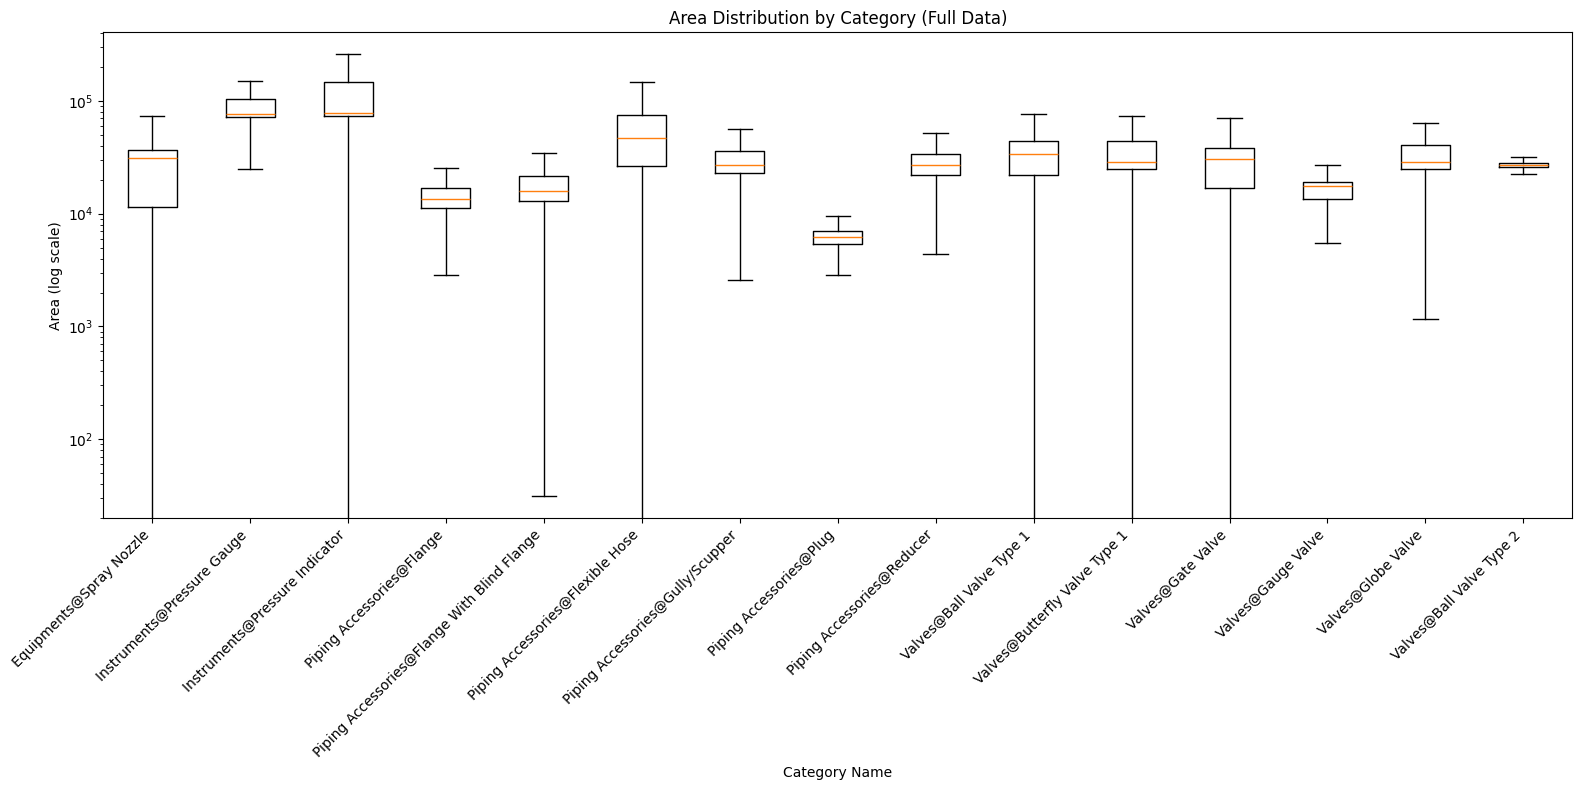

In [8]:
# --- 3. Matplotlib으로 박스 플롯 직접 그리기 ---
# Matplotlib의 bxp(box plot from stats) 함수에 맞는 형식으로 데이터를 변환
plot_stats = []
for index, row in stats_pdf.iterrows():
    plot_stats.append({
        'label': row['name'],
        'med': row['med'],
        'q1': row['q1'],
        'q3': row['q3'],
        'whislo': row['whislo'],
        'whishi': row['whishi'],
        'fliers': [] # 이상치는 계산이 복잡하므로 생략
    })

fig, ax = plt.subplots(figsize=(16, 8))
ax.bxp(plot_stats, showfliers=False) # 계산된 통계치로 박스 플롯 생성
ax.set_yscale('log')
plt.xticks(rotation=45, ha='right')
plt.title('Area Distribution by Category (Full Data)')
plt.xlabel('Category Name')
plt.ylabel('Area (log scale)')
plt.tight_layout()
plt.show()

In [11]:
stats_pdf['name']

id
1209                        Equipments@Spray Nozzle
1512                     Instruments@Pressure Gauge
1513                 Instruments@Pressure Indicator
1715                      Piping Accessories@Flange
1716    Piping Accessories@Flange With Blind Flange
1717               Piping Accessories@Flexible Hose
1719               Piping Accessories@Gully/Scupper
1723                        Piping Accessories@Plug
1726                     Piping Accessories@Reducer
1907                       Valves@Ball Valve Type 1
1908                  Valves@Butterfly Valve Type 1
1920                              Valves@Gate Valve
1921                             Valves@Gauge Valve
1922                             Valves@Globe Valve
1963                       Valves@Ball Valve Type 2
Name: name, dtype: object

In [ ]:
def check_outliers_category(stats_pdf, category_name_to_check):
    # 해당 카테고리의 통계 정보 가져오기
    category_stats = stats_pdf[stats_pdf['name'] == category_name_to_check].iloc[0]
    category_id = category_stats.name

    # 이상치 경계 계산 (IQR 방식)
    q1 = category_stats['q1']
    q3 = category_stats['q3']
    iqr = q3 - q1
    upper_bound = q3 + 1.5 * iqr

    print(f"'{category_name_to_check}' 클래스의 이상치 상한선: {upper_bound:.2f}")

    # Dask로 해당 카테고리에서 이상치에 해당하는 데이터 필터링
    outliers_ddf = annotations_ddf[
        (annotations_ddf['category_id'] == category_id) & 
        (annotations_ddf['area'] > upper_bound)
    ]

    # 이상치 데이터 확인
    print("\n상한선을 벗어나는 이상치 데이터 샘플:")
    display(outliers_ddf.compute().head())
    
    return outliers_ddf

In [9]:
# 확인할 카테고리 이름 선택
category_name_to_check = 'Instruments@Pressure Indicator'
problematic_data = check_outliers_category(stats_pdf, category_name_to_check)

'Instruments@Pressure Indicator' 클래스의 이상치 상한선: 258244.41

상한선을 벗어나는 이상치 데이터 샘플:


,id,image_id,category_id,iscrowd,area,bbox,attributes.vendor,attributes.shipType,attributes.pidLabel,x,y,w,h,x2,y2,aspect_ratio,center_x,center_y
0,1,1,1513,0,566405.76,"[12542.8, 2158.3, 753.6, 751.6]",V03,FPSO,PI,12542.8,2158.3,753.6,751.6,13296.4,2909.9,1.002661,6648.20,1454.95
1,2,1,1513,0,564076.04,"[20175.6, 2158.6, 750.8, 751.3]",V03,FPSO,PI,20175.6,2158.6,750.8,751.3,20926.4,2909.9,0.999334,10463.20,1454.95
19,20,1,1513,0,336341.58,"[4282.5, 133.9, 580.6, 579.3]",V04,FPSO,PI,4282.5,133.9,580.6,579.3,4863.1,713.2,1.002244,2431.55,356.60
26,27,1,1513,0,339068.45,"[6015.3, 2406.9, 584.5, 580.1]",V04,FPSO,PI,6015.3,2406.9,584.5,580.1,6599.8,2987.0,1.007585,3299.90,1493.50
22,23,1,1513,0,338022.35,"[551.3, 342.2, 579.5, 583.3]",V04,FPSO,PI,551.3,342.2,579.5,583.3,1130.8,925.5,0.993485,565.40,462.75


In [ ]:
category_name_to_check = "Equipments@Spray Nozzle"
problematic_data = check_outliers_category(stats_pdf, category_name_to_check)

'Equipments@Spray Nozzle' 클래스의 이상치 상한선: 73575.46

상한선을 벗어나는 이상치 데이터 샘플:


,id,image_id,category_id,iscrowd,area,bbox,attributes.vendor,attributes.shipType,attributes.pidLabel,x,y,w,h,x2,y2,aspect_ratio,center_x,center_y
0,1,1,1209,0,75406.48,"[2688.7, 3942.7, 234.4, 321.7]",V01,Semi-Rig,,2688.7,3942.7,234.4,321.7,2923.1,4264.4,0.728629,1461.55,2132.20
2,3,1,1209,0,73921.95,"[3610.9, 3941.6, 229.5, 322.1]",V01,Semi-Rig,,3610.9,3941.6,229.5,322.1,3840.4,4263.7,0.712512,1920.20,2131.85
3,4,1,1209,0,73892.97,"[4070.0, 3942.2, 228.7, 323.1]",V01,Semi-Rig,,4070.0,3942.2,228.7,323.1,4298.7,4265.3,0.707830,2149.35,2132.65
5,6,1,1209,0,75547.12,"[4986.5, 3942.2, 234.4, 322.3]",V01,Semi-Rig,,4986.5,3942.2,234.4,322.3,5220.9,4264.5,0.727273,2610.45,2132.25
6,7,1,1209,0,75547.12,"[5445.6, 3942.2, 234.4, 322.3]",V01,Semi-Rig,,5445.6,3942.2,234.4,322.3,5680.0,4264.5,0.727273,2840.00,2132.25


In [16]:
unique_ids = images_ddf['id'].unique().compute()

print(f"'id' 컬럼의 고유값: {unique_ids}")
print(f"고유값의 개수: {len(unique_ids)}")

'id' 컬럼의 고유값: 0    1
Name: id, dtype: int64
고유값의 개수: 1


In [15]:
# 확인할 이상치 선택 (예: 첫 번째 행)
# outlier_sample = problematic_data.iloc[:, 0]
outlier_sample_pd = problematic_data.compute().head(1)

if not outlier_sample_pd.empty:
    image_id_to_find = outlier_sample_pd['image_id'].iloc[0]
    print(f"찾으려는 이미지 ID: {image_id_to_find}")

    # 3. 이제 'image_id_to_find'는 실제 값이므로 .loc에서 안전하게 사용할 수 있습니다.
    # 'id' 컬럼을 인덱스로 설정
    images_ddf_indexed = images_ddf.set_index('id')
    
    # .loc으로 특정 id의 'file_name'을 찾고 compute 실행
    image_name_str = images_ddf_indexed.loc[image_id_to_find]['file_name'].compute()

    print(f"찾은 파일 이름: {image_name_str}")

    # 이후 이미지 경로 설정 및 시각화 코드
    image_path = data_path / Path('TS') / str(image_name_str).split('_')[:3] / image_name_str
    
    print(f"path: {image_path}")
else:
    print("이상치 데이터를 찾을 수 없습니다.")

찾으려는 이미지 ID: 1
찾은 파일 이름: id
1    V01_04_006_001_1.png
1    V01_04_006_001_3.png
1    V01_04_006_002_1.png
1    V01_04_006_002_2.png
1    V01_04_006_002_3.png
             ...         
1    V04_02_065_332_2.png
1    V04_02_065_333_1.png
1    V04_02_065_333_2.png
1    V04_02_065_333_3.png
1    V04_02_065_334_1.png
Name: file_name, Length: 18422, dtype: string


TypeError: unsupported operand type(s) for /: 'PosixPath' and 'list'

In [ ]:
# 이미지 불러오기
try:
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # bbox 좌표 추출 (x,y,w,h)
    x, y, w, h = outlier_sample['bbox']
    x, y, w, h = int(x), int(y), int(w), int(h)

    # 이미지에 사각형 그리기
    cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 50) # 빨간색, 두께 50

    # 시각화
    plt.figure(figsize=(15, 10))
    plt.imshow(image)
    plt.title(f"Outlier Check: Image ID {outlier_sample['image_id']}, Area {outlier_sample['area']:.0f}")
    plt.show()

except FileNotFoundError:
    print(f"이미지 파일을 찾을 수 없습니다: {image_path}")

ArrowInvalid: Could not convert PosixPath('/home/rune/dev/pid/assets/TS') with type PosixPath: did not recognize Python value type when inferring an Arrow data type

In [ ]:
# 이미지마다 객체 수가 어떻게 다른가?

# 1. 'image_id' 컬럼의 값별로 개수를 셉니다. (이 단계는 Dask 작업 계획만 수립합니다)
object_counts = annotations_ddf['image_id'].value_counts()

# 2. 실제 계산을 실행하여 결과를 Pandas Series로 가져옵니다.
print("이미지별 객체 수 계산 중...")
object_counts_pd = object_counts.compute()
print("계산 완료.")

# 3. 결과 확인
print("\n--- 이미지별 객체 수 (상위 5개) ---")
print(object_counts_pd.head())

# 추가적인 통계 정보 확인
print("\n--- 통계 요약 ---")
print(f"고유 이미지 수: {len(object_counts_pd)}")
print(f"이미지 당 평균 객체 수: {object_counts_pd.mean():.2f}")
print(f"가장 객체가 많은 이미지의 객체 수: {object_counts_pd.max()}")
print(f"가장 객체가 적은 이미지의 객체 수: {object_counts_pd.min()}")

이미지별 객체 수 계산 중...
계산 완료.

--- 이미지별 객체 수 (상위 5개) ---
image_id
V01_03_026_010_3    22
V03_01_050_236_1    48
V03_01_050_304_3     1
V02_04_010_124_3    25
V01_03_024_103_2    36
Name: count, dtype: int64

--- 통계 요약 ---
고유 이미지 수: 18422
이미지 당 평균 객체 수: 24.54
가장 객체가 많은 이미지의 객체 수: 322
가장 객체가 적은 이미지의 객체 수: 1


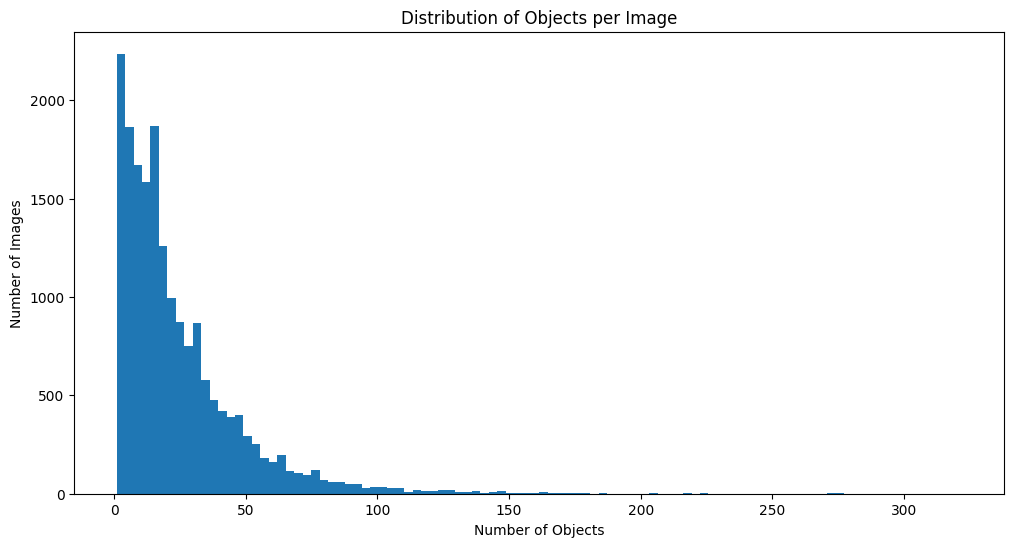

In [10]:
plt.figure(figsize=(12, 6))
object_counts_pd.hist(bins=100) # 막대 개수를 100개로 설정
plt.title('Distribution of Objects per Image')
plt.xlabel('Number of Objects')
plt.ylabel('Number of Images')
plt.grid(False)
plt.show()

In [11]:
# 가장 객체가 많은 이미지의 ID 찾기
max_objects_id = object_counts_pd.idxmax()
print(f"가장 객체가 많은 이미지 ID: {max_objects_id}, 객체 수: {object_counts_pd.max()}")

# 가장 객체가 적은 이미지들의 ID 상위 5개 찾기
min_objects_ids = object_counts_pd.nsmallest(5)
print("\n가장 객체가 적은 이미지들:")
print(min_objects_ids)

가장 객체가 많은 이미지 ID: V04_02_065_271_2, 객체 수: 322

가장 객체가 적은 이미지들:
image_id
V03_01_050_304_3    1
V03_01_050_059_1    1
V04_05_057_111_3    1
V04_01_059_265_2    1
V01_03_036_083_3    1
Name: count, dtype: int64


In [12]:
# 1. 객체 수가 1인 데이터만 필터링합니다.
single_object_images = object_counts_pd[object_counts_pd == 1]

# 2. 필터링된 결과를 출력합니다.
print(f"객체가 1개인 이미지의 총 개수: {len(single_object_images)}")
print("\n--- 객체가 1개인 이미지 ID 목록 (상위 100개) ---")

# 목록이 매우 길 수 있으므로, .head(100)을 사용해 앞의 100개만 먼저 확인합니다.
# 모든 목록을 보려면 .head(100) 부분을 지우면 됩니다.
print(single_object_images.head(100))

객체가 1개인 이미지의 총 개수: 488

--- 객체가 1개인 이미지 ID 목록 (상위 100개) ---
image_id
V03_01_050_304_3    1
V03_01_050_059_1    1
V04_05_057_111_3    1
V04_01_059_265_2    1
V01_03_036_083_3    1
                   ..
V01_03_027_084_2    1
V03_01_050_308_1    1
V01_03_027_023_2    1
V02_04_004_123_1    1
V04_05_058_063_1    1
Name: count, Length: 100, dtype: int64


해상도별 개수 계산 중...
계산 완료.

너비/높이 통계 계산 중...
계산 완료.

--- 이미지 너비/높이 통계 ---
              width        height
count  18422.000000  18422.000000
mean   10348.049995   8890.129193
std     2107.296798   2040.854397
min     2113.000000   1789.000000
25%     9298.000000   7876.000000
50%    10046.000000   8610.000000
75%    11276.000000   9804.000000
max    23751.000000  18254.000000

상위 해상도 시각화 생성 중...


/tmp/ipykernel_17902/3310049032.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_resolutions.values, y=top_resolutions.index, orient='h', palette='viridis')


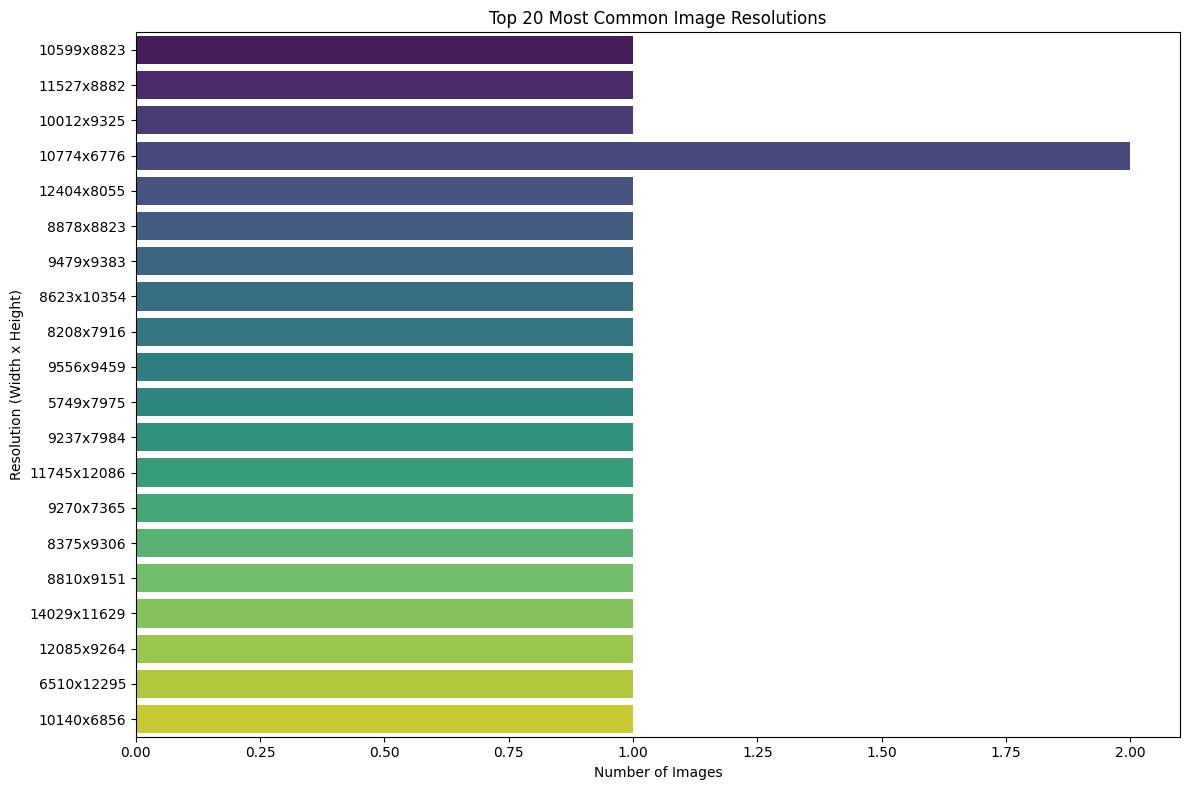

In [13]:
# 이미지 해상도는 다양한가?
# --- 1. 해상도별 개수 계산 (Dask) ---
print("해상도별 개수 계산 중...")
# '너비x높이' 형태의 문자열로 된 새로운 'resolution' 컬럼 생성
images_ddf['resolution'] = images_ddf['width'].astype(str) + 'x' + images_ddf['height'].astype(str)

# 해상도별로 개수를 셈
resolution_counts = images_ddf['resolution'].value_counts()

# 실제 계산 실행
resolution_counts_pd = resolution_counts.compute()
print("계산 완료.")


# --- 2. 너비/높이 통계 계산 (Dask) ---
print("\n너비/높이 통계 계산 중...")
# describe() 함수로 통계 요약
stats_pd = images_ddf[['width', 'height']].describe().compute()
print("계산 완료.")

print("\n--- 이미지 너비/높이 통계 ---")
print(stats_pd)


# --- 3. 상위 해상도 시각화 (Matplotlib/Seaborn) ---
print("\n상위 해상도 시각화 생성 중...")
# 가장 흔한 상위 20개 해상도 선택
top_n = 20
top_resolutions = resolution_counts_pd.head(top_n)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_resolutions.values, y=top_resolutions.index, orient='h', palette='viridis')

plt.title(f'Top {top_n} Most Common Image Resolutions')
plt.xlabel('Number of Images')
plt.ylabel('Resolution (Width x Height)')
plt.tight_layout() # 레이블이 잘리지 않도록 조정
plt.show()

In [7]:
display(categories_df.columns)
display(categories_df.head())

Index(['supercategory', 'name', 'category_group', 'category_name'], dtype='object')

,supercategory,name,category_group,category_name
id,,,,
1102,P&ID,Compressors@Compressor,Compressors,Compressor
1201,P&ID,Equipments@Agitator,Equipments,Agitator
1202,P&ID,Equipments@Eye Washer,Equipments,Eye Washer
1206,P&ID,Equipments@Hose Reel,Equipments,Hose Reel
1209,P&ID,Equipments@Spray Nozzle,Equipments,Spray Nozzle



클래스별 객체 수 계산 중...
계산 완료.

클래스 분포 시각화 생성 중...


/tmp/ipykernel_50438/3682405676.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_counts.head(top_n_classes).values, y=sorted_counts.head(top_n_classes).index, orient='h', palette='rocket_r')


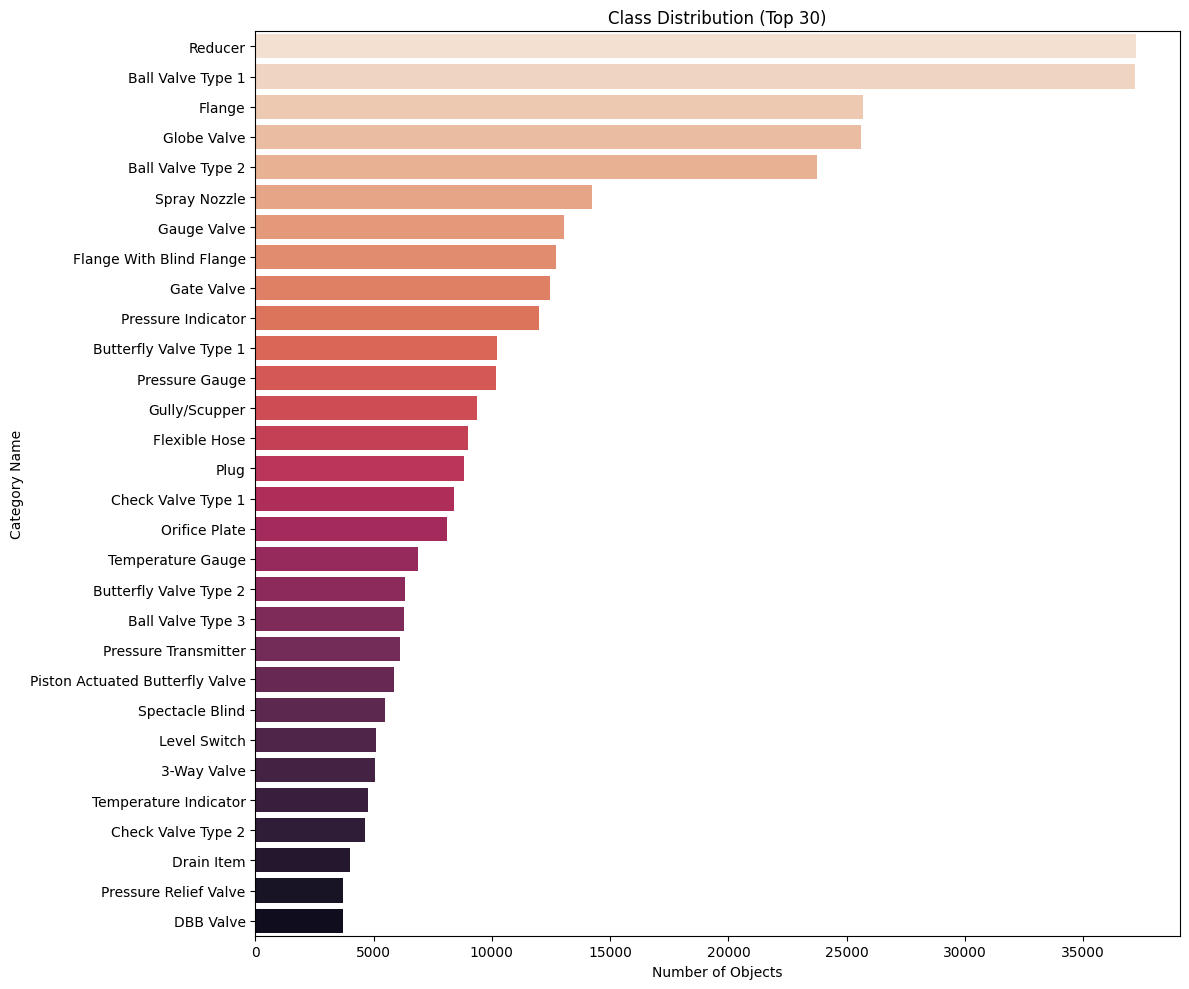


--- 클래스별 객체 수 (상위 10개) ---


category_id
Reducer                     37227
Ball Valve Type 1           37200
Flange                      25688
Globe Valve                 25595
Ball Valve Type 2           23732
Spray Nozzle                14232
Gauge Valve                 13035
Flange With Blind Flange    12728
Gate Valve                  12471
Pressure Indicator          11979
Name: count, dtype: int64


--- 클래스별 객체 수 (하위 10개) ---


category_id
Motor Actuator Valve                  85
Rupture Disc                          84
Different Pressure Indicator Alarm    81
Solenoid Operated Gate Valve          76
Temperature Safety Alarm              67
High Rate Mixer                       42
Pneumatic Actuated Gate Valve         36
Swivel Joint                          36
Insulating Gasket                     31
Flexible Joint                         8
Name: count, dtype: int64

In [9]:
# --- 1. 클래스별 개수 계산 (Dask) ---
# annotations_ddf가 이미 로드되어 있다고 가정합니다.
print("\n클래스별 객체 수 계산 중...")
class_counts = annotations_ddf['category_id'].value_counts()
class_counts_pd = class_counts.compute()
print("계산 완료.")

# --- 2. ID를 클래스 이름으로 변환 ---
# categories_df를 사용해 ID 인덱스를 'category_name'으로 변환
class_counts_pd.index = class_counts_pd.index.map(categories_df['category_name'])
class_counts_pd = class_counts_pd.dropna() # 매핑에 실패한 경우(NaN)는 제거

# --- 3. 분포 시각화 ---
print("\n클래스 분포 시각화 생성 중...")
sorted_counts = class_counts_pd.sort_values(ascending=False)
top_n_classes = 30

plt.figure(figsize=(12, 10))
sns.barplot(x=sorted_counts.head(top_n_classes).values, y=sorted_counts.head(top_n_classes).index, orient='h', palette='rocket_r')

plt.title(f'Class Distribution (Top {top_n_classes})')
plt.xlabel('Number of Objects')
plt.ylabel('Category Name')
plt.tight_layout()
plt.show()

print("\n--- 클래스별 객체 수 (상위 10개) ---")
display(sorted_counts.head(10))
print("\n--- 클래스별 객체 수 (하위 10개) ---")
display(sorted_counts.tail(10))


In [ ]:
# --- 1. 기본 경로 및 파일 경로 설정 ---
base_dir = Path(os.getcwd()).resolve().parent
data_path = base_dir / "assets"
json_path = base_dir / "preprocessed_data_json"

# 카테고리 정보 로드 (필요시 사용)
with (data_path / "categories.json").open("r", encoding="utf-8") as f:
    categories = json.load(f)

categories_df = pd.DataFrame(categories)

# 'name' 컬럼을 '@' 기준으로 분리하여 새로운 컬럼 생성
# .str.split()에 expand=True를 사용하면 분리된 결과가 새로운 컬럼들로 만들어집니다.
categories_df[['category_group', 'category_name']] = categories_df['name'].str.split('@', n=1, expand=True)

# 'id'를 인덱스로 설정하여 특정 카테고리를 빠르게 찾을 수 있도록 함
categories_df = categories_df.set_index('id')

In [ ]:
# 1. 파일을 한번만 읽어 필요한 모든 '부분'을 반환하는 함수
def load_all_parts_from_file(json_file_path):
    """파일을 한 번만 읽고 images와 annotations 리스트를 딕셔너리로 반환합니다."""
    with open(json_file_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    
    return {
        'info': data.get('info', []),
        'images': data.get('images', []),
        'annotations': data.get('annotations', [])
    }

# 파일 목록 가져오기
file_list = sorted(json_path.glob("VL_prepro/VL_*_*/*.json"))

# 2. 각 파일에 대해 로더 함수를 '지연' 실행. (파일 읽기 I/O는 여기서 한 번만 계획됨)
lazy_results = [delayed(load_all_parts_from_file)(f) for f in file_list]

# 3. '지연된' 결과(딕셔너리)를 '재사용'하여 각 데이터프레임을 생성
# 3-1. info 데이터프레임 만들기
lazy_infos_dfs = [delayed(pd.json_normalize)(res['info']) for res in lazy_results]
infos_ddf = dd.from_delayed(lazy_infos_dfs)
# 3-2. images 데이터프레임 만들기
lazy_images_dfs = [delayed(pd.json_normalize)(res['images']) for res in lazy_results]
images_ddf = dd.from_delayed(lazy_images_dfs)

# 3-3. annotations 데이터프레임 만들기
lazy_annotations_dfs = [delayed(pd.json_normalize)(res['annotations']) for res in lazy_results]
annotations_ddf = dd.from_delayed(lazy_annotations_dfs)


# 이제 두 개의 Dask DataFrame이 효율적으로 생성되었습니다.
# print("--- Infos DataFrame Head ---")
# display(infos_ddf.compute().head())

# print("--- Images DataFrame Head ---")
# display(images_ddf.compute().head())

print("\n--- Annotations DataFrame Head ---")
# display(annotations_ddf.compute().head())
# display(annotations_ddf.compute().info())